In [1]:
%matplotlib inline

import random
import timeit
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sklearn.feature_extraction
import sklearn.metrics
import sklearn.model_selection
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Neural network basics 2

In the previous chapter we saw some history about the perceptron and said that people were thinking that this simple model could do very complex things.
Minsky and Papert changed all that when they published their mathematical proof in 1969 showing that perceptrons were not even able to correctly classify whether two inputs are equal or not.
Logistic regression classifiers have this same problem.
Let's see what this means and why.

## The XOR problem

The training set below is meant to make a neural network learn to output a 0 if both inputs are the same and a 1 if both inputs are different, which is known as an exclusive-or (XOR):

| $x_0$ | $x_1$ | $y$ |
|-------|-------|-----|
| 0     | 0     | 0   |
| 0     | 1     | 1   |
| 1     | 0     | 1   |
| 1     | 1     | 0   |

Let's try making a logistic regression classifier learn the above training set:

step error
10 0.6968989372253418
20 0.6943774819374084
30 0.6935734748840332
40 0.6933038234710693
50 0.6932079792022705
60 0.6931718587875366
70 0.6931574940681458
80 0.693151593208313


90 0.6931491494178772
100 0.6931480765342712

x0 x1 y
0.0 0.0 0.4989936947822571
0.0 1.0 0.4999869465827942
1.0 0.0 0.4996972680091858
1.0 1.0 0.5006904602050781


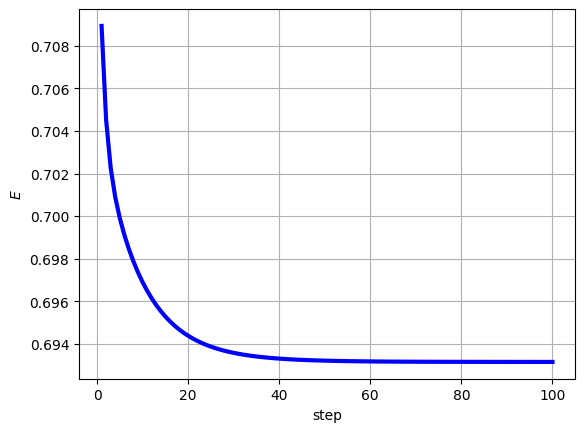

In [2]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32, device=device)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32, device=device)

class Logistic(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(2, 1)

    def forward(self, x):
        return self.linear(x) # Just the logits.

model = Logistic()
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)

print('step', 'error')
train_errors = []
for step in range(1, 100 + 1):
    optimiser.zero_grad()
    logits = model(train_x)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()

    if step%10 == 0:
        print(step, train_errors[-1])
print()

print('x0', 'x1', 'y')
output = torch.sigmoid(model(train_x))[:, 0].detach().cpu().tolist()
for (x, y) in zip(train_x.cpu().tolist(), output):
    print(x[0], x[1], y)

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

The best the model could learn was to make everything 0.5.
There are no parameters that will make the logistic regression classifier give you the right output for all inputs.
We can see why this with a 3D input-output plot of the classifier for different parameters.
To avoid having a difficult-to-see 3D graph, we'll instead be using a heat map that uses colour to show where the output is high (red) and low (blue).

w1: -3.360, w2: -3.802, b:  0.667
w1:  0.528, w2:  3.181, b:  2.242
w1: -2.005, w2: -0.802, b:  1.395
w1: -2.259, w2:  2.272, b: -2.150
w1: -2.304, w2: -3.890, b: -2.506
w1:  2.146, w2:  1.012, b:  1.210
w1:  2.189, w2: -3.222, b: -3.991
w1: -1.642, w2: -1.940, b: -3.538


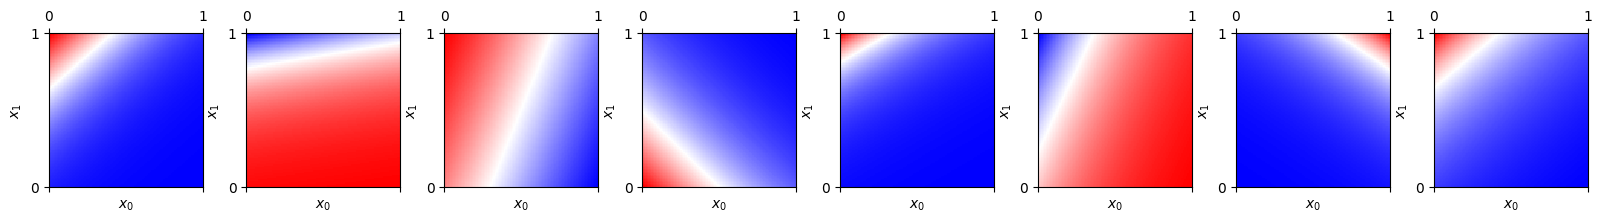

In [3]:
sigmoid = lambda x:1/(1 + np.exp(-x))

(fig, axs) = plt.subplots(1, 8, figsize=(20, 2))
for i in range(8):
    axs[i].set_xlabel('$x_0$')
    axs[i].set_ylabel('$x_1$')

    w1 = 4*(2*np.random.random() - 1)
    w2 = 4*(2*np.random.random() - 1)
    b = 4*(2*np.random.random() - 1)

    (xs1, xs0) = np.mgrid[0:1.01:0.01, 0:1.01:0.01]
    ys = sigmoid(w1*xs0 + w2*xs1 + b)
    axs[i].matshow(ys, cmap='bwr', extent=(0, 1, 0, 1))

    print('w1: {:6.3f}, w2: {:6.3f}, b: {:6.3f}'.format(w1, w2, b))

Our training set is concerned with the four corners of these heat maps.
Each corner corresponds to the input $(0,0)$, $(0,1)$, $(1,0)$, and $(1,1)$.
    In the previous topic, we trained our classifier to make an AND gate where $(0,0)$ output $0$ (blue), $(0,1)$ output $0$ (blue), $(1,0)$ output $0$ (blue), and $(1,1)$ output $1$ (red).
So basically three corners had to be blue whilst the top right corner had to be red.

If you look at how the heat maps change for different parameters, you'd notice that there's always a straight white line separating the red region from the blue region.
Note how the only thing that the parameters change is where the white line is and how it's rotated.
It never curves and there is never more than one of it.
It's easy to imagine how the line should be positioned to get a red top right corner with all the other corners being blue.
Unfortunately, in the case of the XOR training set, there is no position for the white line that works, because we'd need to position the line in such a way to get the coloured corners below:

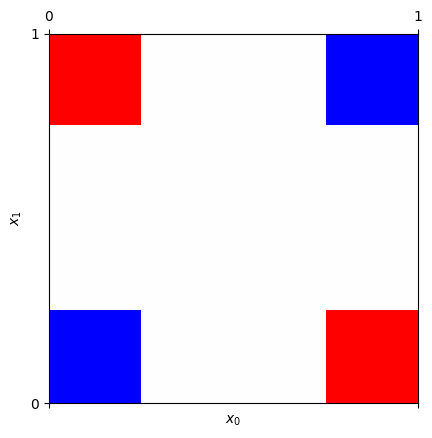

In [4]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')

ys = np.full((100, 100), 0.5)
ys[:25, :25] = 1
ys[:25, -25:] = 0
ys[-25:, -25:] = 1
ys[-25:, :25] = 0
ax.matshow(ys, cmap='bwr', extent=(0, 1, 0, 1))

A single straight line cannot separate reds and blues as shown above, so, given that different parameters can only work with a straight line, this proves that the logistic regression classifier cannot learn the given training set.
We call such problems, that can be solved by a straight line, **linearly separable problems**.
The XOR problem is a **non-linearly separable problem**.

## The hidden layer

When Minsky and Papert published this proof about perceptrons (which was slightly more mathematical than what was shown here), they also gave a solution to it: pass the output of several perceptrons into another perceptron.
A set of perceptrons connected in this way could in fact solve the XOR problem, provided you had the right parameters.
This is what the graphical diagram of such a model looks like:

![](neuron_diagram.png)

The neural units aren't connected randomly, they have to be organised into **layers**.
This means that every unit in one layer is connected to all the units in the next layer, and no where else.
Note how we now need to add a third number to the subscript of the weights and a second number to the subscript of the biases in order to specify in which layer they belong to.

The layers have names: the first layer of neural units is called the **hidden layer**, because you don't get to see the outputs of this layer, and the second layer is called the **output layer**.
The output numbers by each neural unit are called activations.
We can also visualise the architecture as a simplified block diagram:

![](block_diagram.png)

Let's an input-output heat map two-layer neural network trained to solve the XOR problem:

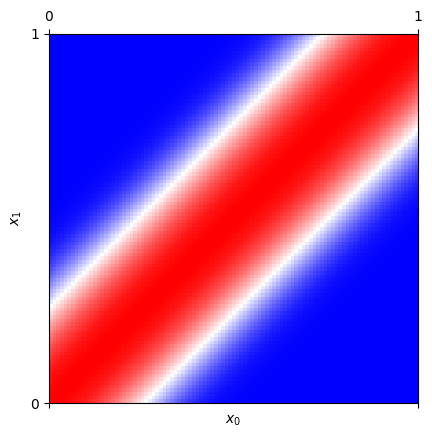

In [5]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')

sigmoid = lambda x:1/(1 + np.exp(-x))
(xs1, xs0) = np.mgrid[0:1.01:0.01, 0:1.01:0.01]
h1 = sigmoid(-10.0*xs0 + -10.0*xs1 + 15.0)
h2 = sigmoid(-10.0*xs0 + -10.0*xs1 + 5.0)
ys = sigmoid(10.0*h1 + -10.0*h2 + -15.0)
ax.matshow(ys, cmap='bwr', extent=(0, 1, 0, 1))

And here we see an example of a non-linear model.
We can now have two slopes in our 3D graph, which allows us to solve the XOR problem.

It's important to keep in mind that each one of the hidden neural units is still performing a linearly separable task.
What's happening is that we are combining two lines together into a single model.
Let's see the heat map of each hidden neural unit:

Text(0.4, 0.4, 'y')

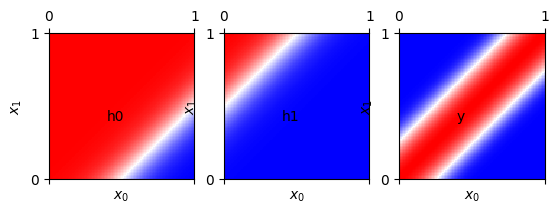

In [6]:
(fig, axs) = plt.subplots(1, 3)
axs[0].set_xlabel('$x_0$')
axs[0].set_ylabel('$x_1$')
axs[1].set_xlabel('$x_0$')
axs[1].set_ylabel('$x_1$')
axs[2].set_xlabel('$x_0$')
axs[2].set_ylabel('$x_1$')

sigmoid = lambda x:1/(1 + np.exp(-x))
(xs1, xs0) = np.mgrid[0:1.01:0.01, 0:1.01:0.01]
h0 = sigmoid(-10.0*xs0 + -10.0*xs1 + 15.0)
h1 = sigmoid(-10.0*xs0 + -10.0*xs1 + 5.0)
ys = sigmoid(10.0*h0 + -10.0*h1 + -15.0)

axs[0].matshow(h0, cmap='bwr', extent=(0, 1, 0, 1))
axs[0].text(0.4, 0.4, 'h0')
axs[1].matshow(h1, cmap='bwr', extent=(0, 1, 0, 1))
axs[1].text(0.4, 0.4, 'h1')
axs[2].matshow(ys, cmap='bwr', extent=(0, 1, 0, 1))
axs[2].text(0.4, 0.4, 'y')

Although it was known that this was possible in 1969, the problem was that everyone was trying to use perceptrons in the hidden layer, that is, use the sign function, which makes the whole neural network undifferentiable.
This is because the sign function has no gradient (it's always 0 as it has no slope steepness to measure).

Leaving out the sign function also doesn't work as it makes the two layers behave exactly like a single layer:

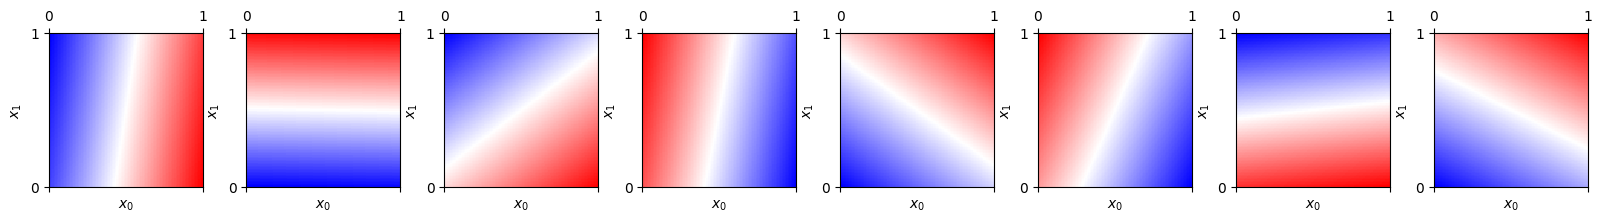

In [7]:
(fig, axs) = plt.subplots(1, 8, figsize=(20, 2))
for i in range(8):
    axs[i].set_xlabel('$x_0$')
    axs[i].set_ylabel('$x_1$')

    w000 = 4*(2*np.random.random() - 1)
    w010 = 4*(2*np.random.random() - 1)
    w001 = 4*(2*np.random.random() - 1)
    w011 = 4*(2*np.random.random() - 1)
    b00 = 4*(2*np.random.random() - 1)
    b01 = 4*(2*np.random.random() - 1)
    w100 = 4*(2*np.random.random() - 1)
    w110 = 4*(2*np.random.random() - 1)
    b10 = 4*(2*np.random.random() - 1)
    
    (xs1, xs0) = np.mgrid[0:1.01:0.01, 0:1.01:0.01]
    hs0 = w000*xs0 + w010*xs1 + b00
    hs1 = w001*xs0 + w011*xs1 + b01
    ys = hs0*w100 + hs1*w110 + b10
    axs[i].matshow(ys, cmap='bwr', extent=(0, 1, 0, 1))

You need some kind of non-linear function, called an **activation function**, in the hidden layer or you'll still be working with something that is effectively a single-layer neural network.

Replacing the sign function with sigmoid function, on the other hand, solves both problems as it is differentiable and non-linear, which is how the XOR problem was solved by Rumelhart, Hinton, and Williams in 1986: feeding the output of a logistic regression classifier into another logistic regression classifier.

Let's use this two-layer neural network in PyTorch:

step error
100 0.4860190749168396


200 0.48121562600135803
300 0.4798169434070587
400 0.4791582226753235
500 0.47877684235572815
600 0.4785287380218506
700 0.478354811668396
800 0.4782261848449707
900 0.4781273305416107
1000 0.47804901003837585

x0 x1 y
0.0 0.0 0.0007405782816931605
0.0 1.0 0.6662077307701111
1.0 0.0 0.6662078499794006
1.0 1.0 0.6668441891670227


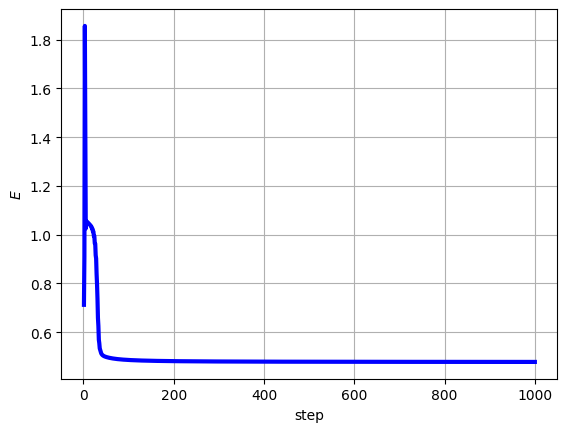

In [8]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32, device=device)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32, device=device)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 2)
        self.layer2 = torch.nn.Linear(2, 1)

    def forward(self, x):
        hidden = torch.sigmoid(self.layer1(x))
        return self.layer2(hidden) # Just the logits.

model = TwoLayer()
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=10.0)

print('step', 'error')
train_errors = []
for step in range(1, 1000+1):
    optimiser.zero_grad()
    logits = model(train_x)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()

    if step%100 == 0:
        print(step, train_errors[-1])
print()

print('x0', 'x1', 'y')
output = torch.sigmoid(model(train_x))[:, 0].detach().cpu().tolist()
for (x, y) in zip(train_x.cpu().tolist(), output):
    print(x[0], x[1], y)

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

Adding more neural units in the hidden layer allows us to create more complex heat map shapes when plotting the model's input-output plot.
Below is a plot of a three unit hidden layer network:

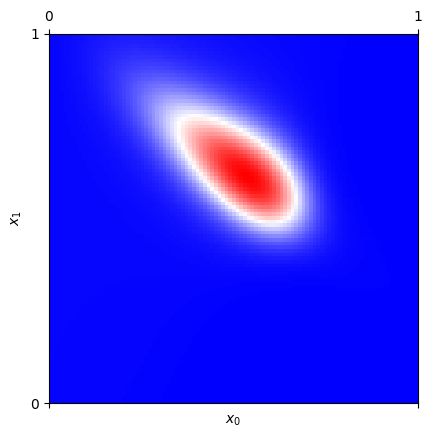

In [9]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')

sigmoid = lambda x:1/(1 + np.exp(-x))
(xs1, xs0) = np.mgrid[0:1.01:0.01, 0:1.01:0.01]
h0 = sigmoid(10.0*xs0 + 5.0*xs1 + -10.0)
h1 = sigmoid(-10.0*xs0 + 10.0*xs1 + 0.0)
h2 = sigmoid(5.0*xs0 + -10.0*xs1 + 0.0)
ys = sigmoid(-10.0*h0 + -10.0*h1 + -10.0*h2 + 5.0)

ax.matshow(ys, cmap='bwr', extent=(0, 1, 0, 1))

A larger hidden layer will allow for more complexity, but is there enough complexity?
Will adding a second hidden layer allow the network to perform even more complex behaviour?

The answer is no: a large enough single hidden layer can perform any task, provided that you find the right parameters.
In fact there is a [mathematical proof](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208) that shows that single hidden layer neural networks (with enough neural units) are **universal approximators**, that is, can have any finite region of their input-output plot be made into approximately any shape.
'Approximately any shape' means that you can get as close as you want but, in many cases, never reach a perfect match.
Note that polynomials are also univeral approximators, given enough terms in the polynomial.

On the other hand, there is also [another mathematical proof](http://proceedings.mlr.press/v49/eldan16.html) that shows that, whilst having two hidden layers does not add more expressiveness than that of a single hidden layer, it does enable the model to require less neural units in total to perform the same task.
So adding more hidden layers results in more efficient networks that can be more complex with less parameters, which is always good.

## Training better

Whilst it is definitely possible to optimise our two layer model to learn many complex behaviour, it is also more difficult to do so than the normal logistic regression classifier.
This is because the error surface is no longer convex.

We can't visualise the parameter-error plot of all 9 parameters as that would require us to plot a 10-dimensional graph.
What we'll do instead is show a 3D slice through the 10-dimensional graph by only varying two of the ten parameters whilst keeping all the other parameters fixed to a random value.
We'll be plotting the error on the XOR training set.

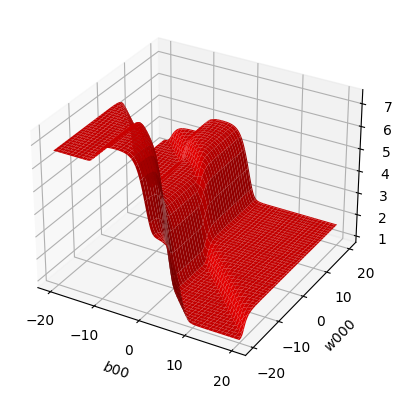

In [10]:
(fig, ax) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.set_xlabel('$b00$')
ax.set_ylabel('$w000$')
ax.set_zlabel('$E$')

w001 = 20*(2*np.random.random() - 1)
w010 = 20*(2*np.random.random() - 1)
w011 = 20*(2*np.random.random() - 1)
b01  = 20*(2*np.random.random() - 1)
w100 = 20*(2*np.random.random() - 1)
w110 = 20*(2*np.random.random() - 1)
b10  = 20*(2*np.random.random() - 1)

sig = lambda x:1/(1 + np.exp(-x))
nn = lambda x0, x1, w000, w001, w010, w011, b00, b01, w100, w110, b10: \
    sig(w100*sig(x0*w000 + x1*w010 + b00) + w110*sig(x0*w001 + x1*w011 + b01) + b10)
f = lambda w000,b00:0.25*(
    -np.log(1 - nn(0, 0, w000, w001, w010, w011, b00, b01, w100, w110, b10)) # target 0
    + -np.log(nn(0, 1, w000, w001, w010, w011, b00, b01, w100, w110, b10)) # target 1
    + -np.log(nn(1, 0, w000, w001, w010, w011, b00, b01, w100, w110, b10)) # target 1
    + -np.log(1 - nn(1, 1, w000, w001, w010, w011, b00, b01, w100, w110, b10)) # target 0
)
(ws, bs) = np.mgrid[-20:20.1:0.1, -20:20.1:0.1]
es = f(ws, bs)
ax.plot_surface(bs, ws, es, color='red', linewidth=0, antialiased=True)

Imagine how complex the entire 10-dimensional graph is.
Due to this complexity, several techniques were developed in order to help with training.

### Batching

Since the error surface is no longer convex, we now run the risk of getting stuck in a **local minimum**, which is a point in the error surface where any small change in parameters will result in a larger error, so training cannot continue, but which is not the smallest error in the entire error surface.
Below is an example:

Text(3.5, 1.0, 'local and global minimum')

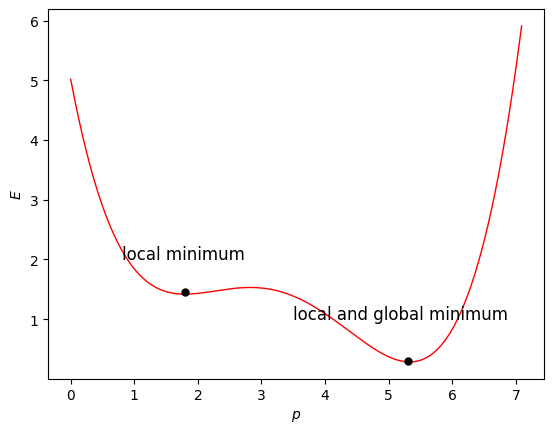

In [11]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$p$')
ax.set_ylabel('$E$')

f = lambda p:0.052*p**4 - 0.69*p**3 + 3.09*p**2 - 5.63*p + 5.02
ps = np.mgrid[0:7.1:0.01]
es = f(ps)
ax.plot(ps, es, color='red', marker='', linestyle='-', linewidth=1)

ax.plot([1.8, 5.3], [1.45, 0.3], color='black', marker='o', markersize=5, linestyle='')
ax.text(0.8, 2.0, 'local minimum', fontdict={'fontsize': 12})
ax.text(3.5, 1.0, 'local and global minimum', fontdict={'fontsize': 12})

Here we see an error surface with a single parameter ($p$) which has two local minima, only one of which is a **global minimum**.
If gradient descent gets you in the first local minimum, it will not be able to escape it (unless the learning rate is large, in which case you'll have bigger problems).

To make gradient descent be able to avoid this problem, we do not calculate the error and its gradient on the entire training set.
Instead we take a random sample of training set rows and calculate the error on that.
This sample is called a **batch**.
After completing an update step on this batch, a different batch is sampled which doesn't share any training items with the first, and another update step is performed based on the new batch, and so on until all the items in the training set have been sampled.
When all the training set has been visited, you have performed an **epoch**.
From now on, we'll refer to steps of training on the entire training set as an epoch and to training on a single batch as a step.

The first advantage of using batches is that you do not need to pass in the entire training set to the neural network, which will likely result in the GPU running out of memory for large data sets.
The second advantage is that, since the error surface depends not only on the model but also the training set, the error surface will be changing with each update, meaning that getting stuck in a local minimum will probably only last for one update step.
After changing the batch you will have a new error surface which will have differently positioned local minima, and, on average, you would be able to continue progressing.

Of course this makes training less stable and the error will tend to fluctuate during training, which is a disadvantage.
To make the process more stable, we use a smaller learning rate in order to avoid going too far off in random directions.
In general, the process tends to improve training and is the standard way to train neural networks.
The optimisation algorithm of using gradient descent with minibatches is called **stochastic gradient descent** (**SGD**) because of the randomness (**stochasticity**) introduced from the random training samples.

The full SGD algorithm works as follows:

1. Randomly shuffle the order of the rows in the training set.
1. Take the first $b$ items, where $b$ is a batch size that you choose.
    This will be the first batch.
1. Now perform an update step on this batch and then take the next $b$ items from the training set.
1. Repeat this process until all the items in the training set have been visited.
1. Having finished an epoch, reshuffle the training set and repeat for a number of epochs.

This guarantees that all the items in the training set are visited equally and that it is unlikely that the same batch of items is used more than once.

Below is how you'd do this in Python.

Start by having your training set defined as a NumPy array instead of a PyTorch tensor.
The batch that will be passed through the model will be placed in a PyTorch tensor but the whole training set does not need to be.

In [12]:
train_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], np.float32)
train_y = np.array([[0], [1], [1], [0]], np.float32)

Since the training set consists of several arrays (`train_x` and `train_y`), we need to shuffle each array correspondingly, otherwise the first item in a 'x' batch will not belong to the first item in the 'y' batch.
The neatest way to do this is to take advantage of NumPy's array indexing features which allow you to pass a list of indexes to an array:

In [13]:
array = np.array([10, 20, 30, 40, 50], np.int64)
indexes = [0, 2, 3]
print(array[indexes])

[10 30 40]


What we'll do is shuffle an array of indexes and then use subarrays of the shuffled indexes to load batches.

In [14]:
print('training set x')
print(train_x)
print('training set y')
print(train_y)
print()

row_indexes = np.arange(len(train_x))
print('row_indexes')
print(row_indexes)
print()

np.random.shuffle(row_indexes)
print('shuffled row_indexes')
print(row_indexes)
print()

batch_row_indexes = row_indexes[0:2]
print('batch_row_indexes')
print(batch_row_indexes)
print()

print('batch x')
print(train_x[batch_row_indexes])
print('batch y')
print(train_y[batch_row_indexes])

training set x
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
training set y
[[0.]
 [1.]
 [1.]
 [0.]]

row_indexes
[0 1 2 3]

shuffled row_indexes
[0 2 3 1]

batch_row_indexes
[0 2]

batch x
[[0. 0.]
 [1. 0.]]
batch y
[[0.]
 [1.]]


This is how you go through all the different batch row indexes in an epoch:

In [15]:
row_indexes = np.arange(len(train_x))
np.random.shuffle(row_indexes)

batch_size = 2
for i in range(0, len(train_x), batch_size):
    print('i:', i)
    batch_row_indexes = row_indexes[i:i+batch_size]
    print('batch_row_indexes:', batch_row_indexes.tolist())
    print('train_x:', train_x[batch_row_indexes].tolist())
    print('train_y:', train_y[batch_row_indexes].tolist())
    print()

i: 0
batch_row_indexes: [0, 2]
train_x: [[0.0, 0.0], [1.0, 0.0]]
train_y: [[0.0], [1.0]]

i: 2
batch_row_indexes: [1, 3]
train_x: [[0.0, 1.0], [1.0, 1.0]]
train_y: [[1.0], [0.0]]



You can now apply a step of gradient descent on each batch extracted from the training set.

Here is the full SGD training process in PyTorch:

epoch step error
50 100 0.9945027828216553
100 200 0.6898828744888306
150 300 0.9821792840957642


200 400 0.9283167123794556
250 500 1.0054439306259155
300 600 0.6960970163345337
350 700 0.6686548590660095
400 800 0.5646225810050964
450 900 0.3439009189605713
500 1000 0.1384432315826416
550 1100 0.08061498403549194
600 1200 0.04770242050290108
650 1300 0.029462048783898354
700 1400 0.025373362004756927
750 1500 0.018279273062944412
800 1600 0.015158246271312237
850 1700 0.013490441255271435
900 1800 0.013701556250452995
950 1900 0.010548708029091358
1000 2000 0.009510628879070282

x0 x1 y
0.0 0.0 0.0081663578748703
0.0 1.0 0.9893103837966919
1.0 0.0 0.9893116354942322
1.0 1.0 0.009471257217228413


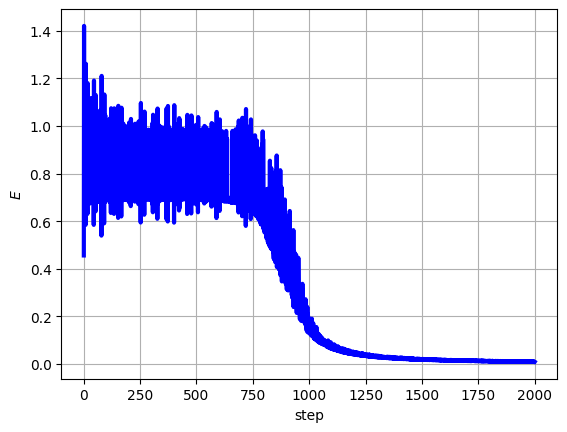

In [16]:
train_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], np.float32)
train_y = np.array([[0], [1], [1], [0]], np.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 2)
        self.layer2 = torch.nn.Linear(2, 1)
        
    def forward(self, x):
        hidden = torch.sigmoid(self.layer1(x))
        return self.layer2(hidden)

model = TwoLayer()
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)

print('epoch', 'step', 'error')
batch_size = 2
train_errors = []
step = 0
for epoch in range(1, 1000+1):
    row_indexes = np.arange(len(train_x))
    np.random.shuffle(row_indexes)

    for i in range(0, len(train_x), batch_size):
        batch_row_indexes = row_indexes[i:i+batch_size]
        batch_x = torch.tensor(train_x[batch_row_indexes], dtype=torch.float32, device=device)
        batch_y = torch.tensor(train_y[batch_row_indexes], dtype=torch.float32, device=device)

        optimiser.zero_grad()
        logits = model(batch_x)
        train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, batch_y)
        train_errors.append(train_error.detach().cpu().tolist())
        train_error.backward()
        optimiser.step()
        
        step += 1
        if step%100 == 0:
            print(epoch, step, train_errors[-1])
print()

# We can also use batching after training.
print('x0', 'x1', 'y')
batch_size = 2
for i in range(0, len(train_x), batch_size):
    batch_x = torch.tensor(train_x[i:i+batch_size], dtype=torch.float32, device=device)
    output = torch.sigmoid(model(batch_x))[:, 0].detach().cpu().tolist()
    for (x, y) in zip(batch_x.cpu().tolist(), output):
        print(x[0], x[1], y)

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

One problem with batching is that you don't get a nice training error per epoch you can show, because that would require going through the training set again after every epoch to get the average error over the whole training set, which would be more time that it's worth.
You can instead show the training error per step, but that would be more noisy.
Note how you can also use batching when simply using the model to get predictions after training (you won't stop running out of memory just because you stopped training).

So what should the batch size be?
The GPU is like a dish washer.
A dish washer only saves time compared to washing dishes by hand when it is loaded with many dishes.
If you only have a single plate to wash, it would be a complete waste of time using the dish washer.
It takes as long for a dish washer to wash one dish as it does to wash twenty, so the more dishes are loaded in the same wash, the more time saved.
GPUs also only make sense to use when they are filled with data since it takes almost the same time to process one training set item as it does to process a hundred.
Furthermore, the time it takes to move data between the GPU and main memory (CPU) and back is a significant fraction of the time it takes to process that data.
Let's quantify these times.

This is how the time it takes to load a batch into GPU varies for different batch sizes, compared to CPU:

In [17]:
durations = {
    'cpu': [],
    'cuda': [],
}
batch_sizes = list(range(250, 1000+1, 250))
for batch_size in batch_sizes:
    for device_ in ['cpu', 'cuda']:
        start_time = timeit.default_timer()
        for _ in range(100):
            x = torch.tensor(np.random.rand(batch_size, 128, 128), dtype=torch.float32, device=device_)
        duration = timeit.default_timer() - start_time
        durations[device_].append(duration)

(fig, ax) = plt.subplots(1, 1)
ax.set_ylabel('duration (seconds)')
ax.set_xlabel('batch size')
for device_ in durations:
    ax.plot(batch_sizes, durations[device_], marker='o', linestyle='-', label=device_)
ax.legend()
ax.grid()

AssertionError: Torch not compiled with CUDA enabled

Note how the GPU always takes longer to load a batch, which is why we should minimise the number of times we move data from CPU to GPU.

This is how the time it takes to load a batch into GPU *and then process it* varies for different batch sizes, compared to CPU:

In [18]:
durations = {
    'cpu': [],
    'cuda': [],
}
batch_sizes = list(range(250, 1000+1, 250))
for batch_size in batch_sizes:
    for device_ in ['cpu', 'cuda']:
        start_time = timeit.default_timer()
        for _ in range(100):
            x = torch.tensor(np.random.rand(batch_size, 128, 128), dtype=torch.float32, device=device_)
            for _ in range(10):
                x = x@x
        duration = timeit.default_timer() - start_time
        durations[device_].append(duration)

(fig, ax) = plt.subplots(1, 1)
ax.set_ylabel('duration (seconds)')
ax.set_xlabel('batch size')
for device_ in durations:
    ax.plot(batch_sizes, durations[device_], marker='o', linestyle='-', label=device_)
ax.legend()
ax.grid()

AssertionError: Torch not compiled with CUDA enabled

We can see how the larger the batch size, the faster the training will be on GPU compared to CPU; so we should use the largest batches possible in order to save time.

But given what we said about avoiding local minima, would smaller batches result in better training since the error surface would change more often?
[The answer is no](https://jmlr.csail.mit.edu/papers/v20/18-789.html).
As long as there is some batching, larger batches do not hurt training progress, provided that the right hidden layer size and learning rate are used, which would be different for different batch sizes.
So find the largest batch you can fit on your GPU and use that, since you have nothing to lose.

### Momentum

Sometimes the error surface is shaped like a valley with a very gentle slope as shown below:

In [ ]:
(fig, ax) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.set_xlabel('$p_0$')
ax.set_ylabel('$p_1$')
ax.set_zlabel('$E$')

f = lambda p0,p1:(p0-5)**2 + 20/(p1+1.0)
(p0s, p1s) = np.mgrid[0:10.1:0.1, 0:10.1:0.1]
es = f(p0s, p1s)
ax.plot_surface(p0s, p1s, es, color='red', linewidth=0, antialiased=True)
ax.view_init(30, 30)

In this case, gradient descent will likely end up moving very slowly down the gentle slope whilst jumping back and forth along the walls of the valley.
This is a problem, because training progress will be very slow and increasing the learning rate will make the parameters shoot out of the valley due to the steep sides.
There is a simple solution to this: **momentum**.

The word momentum is a reference to an object 'picking up momentum' as it rolls down a hill faster and faster, making it harder to slow down or change direction.
In gradient descent we can do something like that by adding a fraction of the previous update to the new update.
Consider the gradient descent update equation:

$$p_{t+1} = p_t - \alpha \nabla_{p_t}$$

where $p_t$ is the parameter to update, $p_{t+1}$ is the updated parameter, $\alpha$ is the learning rate, and $\nabla_{p_t}$ is the gradient with respect to the parameter.
We can think of $\nabla_{p_t}$ as the velocity with which we are moving along the parameter's direction.
We shall now modify it so that a fraction of the previous velocity is added to the current velocity:

$$v_{t+1} = \mu v_t + \nabla_{p_t}$$
$$p_{t+1} = p_t - \alpha v_{t+1}$$

where $\mu$ is the fraction of the previous velocity to apply to the update step, called the momentum.
The bigger $\mu$ is, the less gradient descent will be affected by the current gradient and the more it will be affected by the total of the previous gradients during training.
In the case of the above valley situation, this will make the extent of jumping back and forth across the walls of the valley become smaller and smaller as the gradient in that direction will constantly oscillate from positive to negative, making the total of the gradients in that direction approach zero.
It will also accelerate the movement along the gentle slope as the total gradient is constantly increasing.

Note that normal gradient descent is just momentum with $\mu = 0$.

To use it in PyTorch is very easy, just add a `momentum` parameter to `SGD`.

In [ ]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32, device=device)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32, device=device)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 2)
        self.layer2 = torch.nn.Linear(2, 1)

    def forward(self, x):
        hidden = torch.sigmoid(self.layer1(x))
        return self.layer2(hidden)

model = TwoLayer()
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=1.0, momentum=0.9)

print('step', 'error')
train_errors = []
for step in range(1, 1000+1):
    optimiser.zero_grad()
    logits = model(train_x)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()

    if step%100 == 0:
        print(step, train_errors[-1])
print()

print('x0', 'x1', 'y')
output = torch.sigmoid(model(train_x))[:, 0].detach().cpu().tolist()
for (x, y) in zip(train_x.cpu().tolist(), output):
    print(x[0], x[1], y)

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

There are also other more advanced gradient descent optimisers, such as Adam, which adapts the learning rate during training based on the previous gradients measured.
It also adapts a different learning rate for each parameter rather than use one learning rate for all parameters, which is useful.

To use the Adam optimiser in PyTorch, use the following:

    optimiser = torch.optim.Adam(model.parameters(), lr=0.1)

### Unstable gradients

Adding more layers often results in a problem called **the unstable gradient problem**.
This is when the gradients of layers closer to the input will get either smaller and smaller to the point of becoming neglible, known as **the vanishing gradients problem**, or else it becomes larger and larger to the point of creating invalid values like `inf` and `nan`, known as **the exploding gradients problem**.
The first is much more common.
This happens because the gradient at a particular layer is the product of the activations of all the layers in front of it.

One common focus of research in this problem has to do with the use of sigmoid as an activation function, whose gradient can be very small (or very large, but this is less common).
Below, we're taking a bunch of randomly set two-layer networks and calculating the average magnitude of the gradients with respect to the weights of each layer.
We then plot the gradients to see how the gradients of the hidden layer are different from the graidents of the output layer.

In [ ]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32, device=device)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32, device=device)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(20*(2*torch.rand((2, 2), dtype=torch.float32) - 1))
        self.b1 = torch.nn.Parameter(20*(2*torch.rand((2,), dtype=torch.float32) - 1))
        self.w2 = torch.nn.Parameter(20*(2*torch.rand((2, 1), dtype=torch.float32) - 1))
        self.b2 = torch.nn.Parameter(20*(2*torch.rand((1,), dtype=torch.float32) - 1))

    def forward(self, x):
        hidden = torch.sigmoid(x@self.w1 + self.b1)
        return hidden@self.w2 + self.b2

w1_grads = []
w2_grads = []
for _ in range(100):
    model = TwoLayer()
    model.to(device)

    logits = model(train_x)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
    train_error.backward()

    w1_grads.append(model.w1.grad.abs().mean().cpu().tolist())
    w2_grads.append(model.w2.grad.abs().mean().cpu().tolist())

    for param in model.parameters():
        param.grad.zero_()

(fig, axs) = plt.subplots(1, 2)
axs[0].set_title('gradients of $w_1$')
axs[0].bar(np.arange(len(w1_grads)), w1_grads)
axs[0].grid()
axs[1].set_title('gradients of $w_2$')
axs[1].bar(np.arange(len(w2_grads)), w2_grads)
axs[1].grid()

Note how the majority of the gradients of $w_1$, the weights of the hidden layer, are tend to be much smaller than those of $w_2$, the weights of the output layer.
The more layers you add, the smaller the gradients of the early layers get, which makes training them by gradient descent difficult or even impossible (their weights just don't change during training).

Using a hidden layer activation function that allows for larger gradients will reduce this problem, although it won't eliminate it.
A popular activation function for this purpose is the **rectified linear unit** (**ReLU**), which is defined as

$$y = \max(0, x)$$

that is, leave the input as-is when it is positive and replace it with zero when it is negative.
In PyTorch, this is defined as:

    torch.nn.functional.relu(x)

In [ ]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

xs = np.mgrid[-10:10.1:0.01]
ys = np.maximum(0, xs)
ax.plot(xs, ys, color='red', marker='', linestyle='-', linewidth=1)
ax.text(-5, 6, '$y = \max(0, x)$', color='red', fontdict={'fontsize': 12})
ax.grid()

Let's see how the gradients of the two layers vary now:

In [ ]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32, device=device)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32, device=device)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(20*(2*torch.rand((2, 2), dtype=torch.float32) - 1))
        self.b1 = torch.nn.Parameter(20*(2*torch.rand((2,), dtype=torch.float32) - 1))
        self.w2 = torch.nn.Parameter(20*(2*torch.rand((2, 1), dtype=torch.float32) - 1))
        self.b2 = torch.nn.Parameter(20*(2*torch.rand((1,), dtype=torch.float32) - 1))

    def forward(self, x):
        hidden = torch.nn.functional.relu(x@self.w1 + self.b1)
        return hidden@self.w2 + self.b2

w1_grads = []
w2_grads = []
for _ in range(100):
    model = TwoLayer()
    model.to(device)

    logits = model(train_x)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
    train_error.backward()

    w1_grads.append(model.w1.grad.abs().mean().cpu().tolist())
    w2_grads.append(model.w2.grad.abs().mean().cpu().tolist())

    for param in model.parameters():
        param.grad.zero_()

(fig, axs) = plt.subplots(1, 2)
axs[0].set_title('gradients of $w_1$')
axs[0].bar(np.arange(len(w1_grads)), w1_grads)
axs[0].grid()
axs[1].set_title('gradients of $w_2$')
axs[1].bar(np.arange(len(w2_grads)), w2_grads)
axs[1].grid()

The gradients are look more balanced than with sigmoid (although the scale is still different).

However, ReLU has a problem known as **the dead ReLU problem**, which is when a lot of your neural units end up always outputting zero, regardless of what the neural network's input is.
To prevent this, the **Leaky ReLU** is sometimes used instead which replaces the zero with a fraction of the input such as

$$y = \max\left(\frac{1}{10}x, x\right)$$

In [ ]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

xs = np.mgrid[-10:10.1:0.01]
ys = np.maximum(0.1*xs, xs)
ax.plot(xs, ys, color='red', marker='', linestyle='-', linewidth=1)
ax.text(-5, 6, '$y = \max\\left(\\frac{1}{10}x, x\\right)$', color='red', fontdict={'fontsize': 12})
ax.grid()

which in PyTorch is defined as

    torch.nn.functional.leaky_relu(x, 0.1)

In [ ]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32, device=device)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32, device=device)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 2)
        self.layer2 = torch.nn.Linear(2, 1)

    def forward(self, x):
        hidden = torch.nn.functional.leaky_relu(self.layer1(x), 0.1)
        return self.layer2(hidden) # Sigmoid can still be used for the output (although we only return the logits here).

model = TwoLayer()
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)

print('step', 'error')
train_errors = []
for step in range(1, 1000+1):
    optimiser.zero_grad()
    logits = model(train_x)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()

    if step%100 == 0:
        print(step, train_errors[-1])
print()

print('x0', 'x1', 'y')
output = torch.sigmoid(model(train_x))[:, 0].detach().cpu().tolist()
for (x, y) in zip(train_x.cpu().tolist(), output):
    print(x[0], x[1], y)

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

Note that the output layer can use whatever activation function your want as it will affect all layers equally.

## Avoiding overfitting

When a model makes very good predictions on the training set but bad predictions on other data, we say that the model has overfitted to the training set, which is bad.
Ideally, the model learns something that generalises to other data.

Let's see some ways to reduce this effect.

### Early stopping

The easiest way to avoid overfitting is by using **early stopping**.
Keep a small part of the training set separate, called a **validation set**, and don't use it for training.
Instead, use it to measure performance after every epoch (such as for measuring the model's accuracy).
This will tell you whether the model is just learning the training set by heart or if it's generalising to data outside of the training set.
By monitoring the performance on the validation set, you can stop training as soon as the performance starts degrading, hence why it's called early stopping.

Rather than stopping exactly on the epoch where performance dips, a number of 'bad' epochs should be allowed in order to allow for some fluctuations.
The model parameters are saved every time the validation set performance improves so that the best performing parameters can be loaded at the end.
The maximum number of less-than-best epochs to allow is called the **patience**.

Performance tip: Avoid having PyTorch preparing to compute gradients when not necessary (such as when using the model outside of training) by putting your module calls in a `torch.no_grad()` context:

    with torch.no_grad():
        output = torch.sigmoid(model(train_x))

Below is an example of how to use early stopping.
Since we're using the XOR task, it doesn't make sense to split the 4 row training set into a smaller training set and a validation set.
Instead, we'll be using inputs that are similar to those in the training set as a validation set.

In [ ]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32, device=device)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32, device=device)

val_x = torch.tensor([[-0.1, -0.1], [-0.1, 1.1], [1.1, -0.1], [1.1, 1.1]], dtype=torch.float32, device=device)
val_y = np.array([[0], [1], [1], [0]], np.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 2)
        self.layer2 = torch.nn.Linear(2, 1)

    def forward(self, x):
        hidden = torch.sigmoid(self.layer1(x))
        return self.layer2(hidden)

model = TwoLayer()
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)
best_val_acc = 0.0
patience = 500
num_bad_epochs = 0

print('step', 'error', 'val_acc')
train_errors = []
accs = []
for step in range(1, 10000+1):
    optimiser.zero_grad()
    logits = model(train_x)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()
    
    with torch.no_grad():
        output = torch.sigmoid(model(val_x))[:, 0].round(decimals=0).cpu().numpy()
    val_acc = sklearn.metrics.accuracy_score(output, val_y)
    accs.append(val_acc)
    
    if val_acc > best_val_acc:
        torch.save(model, 'model.pkl')
        best_val_acc = val_acc
        num_bad_epochs = 0
    else:
        num_bad_epochs += 1
        if num_bad_epochs == patience:
            break

    if step%100 == 0:
        print(step, train_errors[-1], val_acc)
print()

# Load the best model found (the one that was saved last) after training.
best_model = torch.load('model.pkl')
print('ended on step:', step)
print('best val acc: {:.0%}'.format(best_val_acc))
print()

print('x0', 'x1', 'y')
with torch.no_grad():
    output = torch.sigmoid(model(train_x))[:, 0].detach().cpu().tolist()
for (x, y) in zip(train_x.cpu().tolist(), output):
    print(x[0], x[1], y)

(fig, axs) = plt.subplots(1, 2)
axs[0].set_xlabel('step')
axs[0].set_ylabel('E')
axs[0].plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
axs[0].grid()
axs[1].set_xlabel('step')
axs[1].set_ylabel('acc')
axs[1].plot(range(1, len(accs) + 1), accs, color='red', linestyle='-', linewidth=3)
axs[1].grid()

### Dropout

Anything that makes training more difficult with the intention of improving generalisation is called **regularisation**.
Dropout is a form of neural network regularisation that consists of zeroing out a random set of hidden layer neural units, that is, dropping them out.
The way it works is that the activations of a hidden layer are multiplied by an array of ones and zeros, called a **mask**, and the result is what is sent to the next layer.
The zeroes in the mask array are filled randomly using some probability called the **dropout rate**, and each separate row in the training set is given a new generated mask which is then regenerated after each epoch.

Why does this act as regularisation?
The hidden layer tends to develop co-adapted groups of neural units that work together to perform a single function as a team.
When these groups become large, there will also be less of them because the number of neural units in a layer is fixed.
A few complex functions are more likely to overfit than many independent simple functions because complex functions are more likely to latch on to a single accidentally reliable feature which is not reliable outside of the training set.
Having many simple functions, on the other hand, makes it more likely that some of them will learn something that will also be found outside of the training set.
The fact that a neural unit cannot depend on a group of neural units being present in the previous layer prevents it from forming large co-adapted groups, leaving only small groups being formed.

![](dropout.png)

This is how you make a mask with a small number of zeros in it in order to multiply it to the hidden layer's activations.

In [ ]:
hidden = torch.rand(3, 4, dtype=torch.float32, device=device) # Make a random hidden layer activation tensor.
print('original hidden activations:')
print(hidden)
print()

mask = torch.rand_like(hidden) # Make a tensor with random numbers between 0 and 1 of the same shape as 'hidden'.
print('random numbers for mask:')
print(mask)
print()

mask = mask > 0.2 # Replace the numbers with True and False depending on whether they are greater than the dropout rate. Since the random numbers are uniformly distributed, the chance of them being less than the dropout rate is equal to the dropout rate.
print('binarised mask with dropout rate 0.2:')
print(mask)
print()

hidden = hidden*mask
print('new hidden activations after dropout:')
print(hidden)

Of course, you don't want to use dropout when the model is being used outside of training as that would result in random outputs.
On the other hand, you can't just remove the mask array and carry on because a neural unit would be trained to expect only a few of the previous layer's neural units being non-zero.
Removing the mask would mean that the neural units are suddenly being fed the activations of the entire previous layer, which will overload the neural unit that was trained on less inputs.
So if the dropout rate was 0.5 (half of the activations were being replaced by zeros on average), what we do is make them double the value of the activations so that the next layer's neural units learn to work with twice the activation total they see during training.
In this way, removing the mask (and the doubling of activations) will make the neural units receive the same total activations they were receiving during training (on average).
In general, for a dropout rate of $p$, the activations of a layer with dropout during training should be multiplied by $\frac{1}{1 - p}$.

We will also need larger hidden layers to compensate for the dropped out neural units and a smaller learning rate due to only a fraction of the units being available during training.

To know whether to use dropout or not, depending on whether it is being trained or not, PyTorch modules provide the attribute `self.training` which is set to true when `model.train()` is called and to false when `model.eval()` is called.

step error
500 0.781495213508606
1000 0.8316209316253662
1500 0.5040802955627441
2000 0.1783456802368164
2500 0.37605738639831543
3000 0.8122396469116211
3500 0.41785886883735657
4000 0.19535401463508606
4500 0.2393111288547516
5000 0.20563828945159912

x0 x1 y
0.0 0.0 0.023501813411712646
0.0 1.0 0.9941543936729431
1.0 0.0 0.931999921798706
1.0 1.0 0.3020038306713104


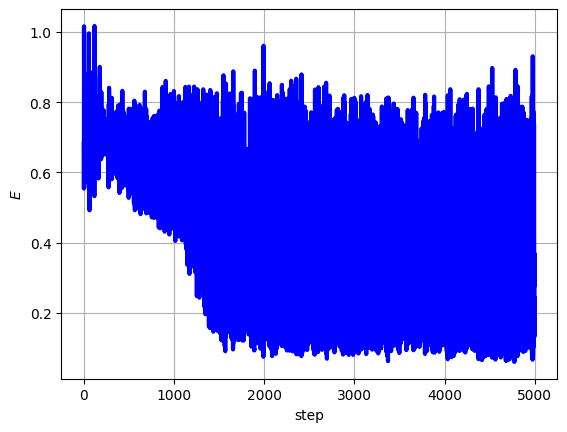

In [19]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32, device=device)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32, device=device)

class TwoLayer(torch.nn.Module):

    def __init__(self, dropout_rate):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.layer1 = torch.nn.Linear(2, 4) # A larger hidden layer.
        self.layer2 = torch.nn.Linear(4, 1)

    def forward(self, x):
        hidden = torch.sigmoid(self.layer1(x))
        if self.training: # Only apply while training.
            mask = torch.rand_like(hidden) # Make a tensor with random numbers between 0 and 1 of the same shape as 'hidden'.
            mask = mask > self.dropout_rate
            hidden = hidden*mask
            hidden = hidden*(1/(1 - self.dropout_rate))
        return self.layer2(hidden)

model = TwoLayer(dropout_rate=0.5)
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)

print('step', 'error')
train_errors = []
for step in range(1, 5000+1):
    model.train() # Set training mode to use dropout.
    optimiser.zero_grad()
    logits = model(train_x)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()

    if step%500 == 0:
        print(step, train_errors[-1])
print()

print('x0', 'x1', 'y')
model.eval() # End training mode to stop using dropout.
with torch.no_grad():
    output = torch.sigmoid(model(train_x))[:, 0].detach().cpu().tolist()
    for (x, y) in zip(train_x.cpu().tolist(), output):
        print(x[0], x[1], y)

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

PyTorch provides a `torch.nn.functional.dropout` function which performs dropout for us.

step error
500 0.656663179397583
1000 0.7965395450592041
1500 0.3684820830821991
2000 0.3654749393463135
2500 0.4983677864074707
3000 0.5986325144767761
3500 0.4964343011379242
4000 0.5597180128097534
4500 0.4927222430706024
5000 0.48188668489456177

x0 x1 y
0.0 0.0 0.0009466755436733365
0.0 1.0 0.9706304669380188
1.0 0.0 0.6346190571784973
1.0 1.0 0.6371195912361145


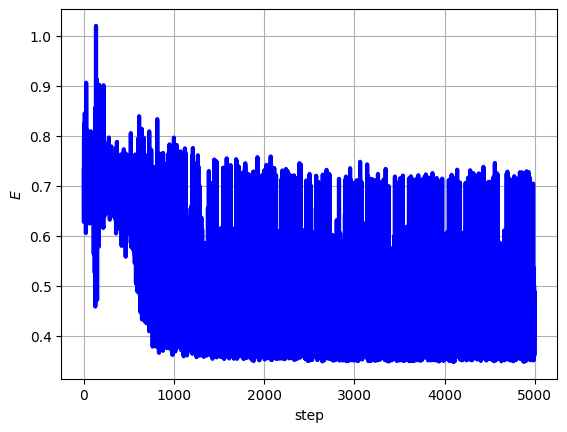

In [20]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32, device=device)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32, device=device)

class TwoLayer(torch.nn.Module):

    def __init__(self, dropout_rate):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.layer1 = torch.nn.Linear(2, 4)
        self.layer2 = torch.nn.Linear(4, 1)

    def forward(self, x):
        hidden = torch.sigmoid(self.layer1(x))
        if self.training:
            hidden = torch.nn.functional.dropout(hidden, self.dropout_rate)
        return self.layer2(hidden)

model = TwoLayer(dropout_rate=0.5)
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)

print('step', 'error')
train_errors = []
for step in range(1, 5000+1):
    model.train()
    optimiser.zero_grad()
    logits = model(train_x)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()

    if step%500 == 0:
        print(step, train_errors[-1])
print()

print('x0', 'x1', 'y')
model.eval()
with torch.no_grad():
    output = torch.sigmoid(model(train_x))[:, 0].detach().cpu().tolist()
    for (x, y) in zip(train_x.cpu().tolist(), output):
        print(x[0], x[1], y)

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

## Hyperparameter tuning

We've seen many ways to improve the performance of a neural network, but many of these ways introduce numbers that need to be set before training: the learning rate, the hidden layer size, the momentum, the leaky ReLU factor, the dropout rate, and so on.
Each one of these numbers that are not taken care of by the optimiser during training are called **hyperparameters**, and they are one of the biggest headaches in deep learning.
This is because there is no simple way to find them, other than by trial and error.
You try a set of hyperparameter values, train the neural network with them, see how it performs, and try another set of values until you get satisfactory performance.
This wouldn't be so bad were it not for the fact that big neural networks take long to train and evaluate.

The search can be automated of course, but it will take the vast majority of the time of developing a neural network (provided that you're not making a data set for your neural network, which would take much longer).
We need to be smart with what hyperparameter values to try, in order to reduce our **search space** and thus reduce the search time.
To evaluate a neural network model, we should use a separate data set called a **development set** (**dev set**).
This would be different from both the validation set that is used for early stopping and the **test set** that is used to to evaluate the final model after hyperparameter tuning.
The test set should be a representation of the inputs received when you use the model in the real world, which would not be the same ones used during hyperparameter tuning or early stopping.

A simple and effective way to search is to use a **random search**.
This is when the hyperparameters values to use are sampled randomly from the search space for a set number of times.
Be sure not to sample the same combination of hyperparameter values more than once.

Here's an example:

In [21]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32, device=device)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32, device=device)

dev_x = torch.tensor([[-0.1, -0.1], [-0.1, 1.1], [1.1, -0.1], [1.1, 1.1]], dtype=torch.float32, device=device)
dev_y = np.array([[0], [1], [1], [0]], np.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self, hidden_layer_size, leaky_relu_factor):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, hidden_layer_size)
        self.layer2 = torch.nn.Linear(hidden_layer_size, 1)
        self.leaky_relu_factor = leaky_relu_factor

    def forward(self, x):
        hidden = torch.nn.functional.leaky_relu(self.layer1(x), self.leaky_relu_factor)
        return self.layer2(hidden)

# The search space consisting of 3*3*3 = 27 possible hyperparameter value combinations.
hidden_layer_size_set = [1, 2, 4]
leaky_relu_factor_set = [0.1, 0.01, 0.001]
learning_rate_set = [10.0, 1.0, 0.1]

already_generated = set()
best_dev_acc = 0.0
best_hyperparams = None
for i in range(1, 10+1): # There are 27 combinations but we're only going to try a random 10 of them.
    while True: # Repeatedly generate random combinations until a new combination is produced.
        hidden_layer_size = random.choice(hidden_layer_size_set)
        leaky_relu_factor = random.choice(leaky_relu_factor_set)
        learning_rate = random.choice(learning_rate_set)
        hyperparams = (hidden_layer_size, leaky_relu_factor, learning_rate)
        if hyperparams not in already_generated:
            already_generated.add(hyperparams)
            break
    print('Hyperparameter search attempt:', i)
    print('hidden_layer_size:', hidden_layer_size)
    print('leaky_relu_factor:', leaky_relu_factor)
    print('learning_rate:', learning_rate)
    
    model = TwoLayer(hidden_layer_size, leaky_relu_factor)
    model.to(device)
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)
    for step in range(1, 1000+1):
        optimiser.zero_grad()
        logits = model(train_x)
        train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
        train_error.backward()
        optimiser.step()
    
    with torch.no_grad():
        output = torch.sigmoid(model(dev_x))[:, 0].round(decimals=0).detach().cpu().numpy()
        dev_acc = sklearn.metrics.accuracy_score(output, dev_y)
    print('Dev set accuracy:', dev_acc)
    if dev_acc > best_dev_acc:
        best_hyperparams = hyperparams
        best_dev_acc = dev_acc
        torch.save(model, 'best_model.pkl')
        print('new best!')
    print()

(hidden_layer_size, leaky_relu_factor, learning_rate) = best_hyperparams
print('Best found:')
print('hidden_layer_size:', hidden_layer_size)
print('leaky_relu_factor:', leaky_relu_factor)
print('learning_rate:', learning_rate)
print('Dev set accuracy:', best_dev_acc)

best_model = torch.load('best_model.pkl')

Hyperparameter search attempt: 1
hidden_layer_size: 2
leaky_relu_factor: 0.001
learning_rate: 1.0
Dev set accuracy: 0.5
new best!

Hyperparameter search attempt: 2
hidden_layer_size: 2
leaky_relu_factor: 0.01
learning_rate: 1.0
Dev set accuracy: 0.5

Hyperparameter search attempt: 3
hidden_layer_size: 2
leaky_relu_factor: 0.01
learning_rate: 10.0
Dev set accuracy: 0.5

Hyperparameter search attempt: 4
hidden_layer_size: 4
leaky_relu_factor: 0.001
learning_rate: 0.1
Dev set accuracy: 0.5

Hyperparameter search attempt: 5
hidden_layer_size: 1
leaky_relu_factor: 0.001
learning_rate: 1.0
Dev set accuracy: 0.5

Hyperparameter search attempt: 6
hidden_layer_size: 1
leaky_relu_factor: 0.1
learning_rate: 10.0
Dev set accuracy: 0.5

Hyperparameter search attempt: 7
hidden_layer_size: 2
leaky_relu_factor: 0.1
learning_rate: 0.1
Dev set accuracy: 0.75
new best!

Hyperparameter search attempt: 8
hidden_layer_size: 4
leaky_relu_factor: 0.001
learning_rate: 10.0
Dev set accuracy: 0.5

Hyperparameter

## Exercises

### 1) Full extras

Repeat last topic's example (the movie reviews classification task) but this time try to maximise the test set performance by using all the techniques shown in this topic.
All the data preprocessing and validation set extraction has been done for you.

In [45]:
train_df = pd.read_csv('../data_set/sentiment/train.csv')
dev_df = pd.read_csv('../data_set/sentiment/dev.csv')
test_df = pd.read_csv('../data_set/sentiment/test.csv')

train_x = train_df['text']
train_y = train_df['class']
(train_x, val_x, train_y, val_y) = sklearn.model_selection.train_test_split(train_x, train_y, test_size=0.1, random_state=0)
dev_x = dev_df['text']
dev_y = dev_df['class']
test_x = test_df['text']
test_y = test_df['class']
categories = ['neg', 'pos'] # neg -> 0, pos -> 1
cat2idx = {cat: i for (i, cat) in enumerate(categories)}

train_y_idx = train_y.map(cat2idx.get).to_numpy()
val_y_idx = val_y.map(cat2idx.get).to_numpy()
dev_y_idx = dev_y.map(cat2idx.get).to_numpy()
test_y_idx = test_y.map(cat2idx.get).to_numpy()

nltk.download('punkt')
encoder = sklearn.feature_extraction.text.CountVectorizer(max_features=1000, binary=True, stop_words='english', lowercase=True, tokenizer=nltk.word_tokenize, dtype=np.float32)
encoder.fit(train_x)

vocabulary = sorted(encoder.vocabulary_.keys(), key=encoder.vocabulary_.get)

train_x_bow = encoder.transform(train_x).toarray()
val_x_bow = encoder.transform(val_x).toarray()
dev_x_bow = encoder.transform(dev_x).toarray()
test_x_bow = encoder.transform(test_x).toarray()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\User\anaconda3\envs\deep_learning\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [50]:
train_x_bow.shape

(9000, 1000)

In [54]:
class TwoLayer2(torch.nn.Module):

    def __init__(self, hidden_layer_size, leaky_relu_factor):
        super().__init__()
        self.layer1 = torch.nn.Linear(9000, hidden_layer_size)
        self.layer2 = torch.nn.Linear(hidden_layer_size, 1)
        self.leaky_relu_factor = leaky_relu_factor

    def forward(self, x):
        hidden = torch.nn.functional.leaky_relu(self.layer1(x), self.leaky_relu_factor)
        return self.layer2(hidden)

# The search space consisting of 3*3*3 = 27 possible hyperparameter value combinations.
hidden_layer_size_set = [1, 2, 4]
leaky_relu_factor_set = [0.1, 0.01, 0.001]
learning_rate_set = [10.0, 1.0, 0.1]

already_generated = set()
best_dev_acc = 0.0
best_hyperparams = None
for i in range(1, 10+1): # There are 27 combinations but we're only going to try a random 10 of them.
    while True: # Repeatedly generate random combinations until a new combination is produced.
        hidden_layer_size = random.choice(hidden_layer_size_set)
        leaky_relu_factor = random.choice(leaky_relu_factor_set)
        learning_rate = random.choice(learning_rate_set)
        hyperparams = (hidden_layer_size, leaky_relu_factor, learning_rate)
        if hyperparams not in already_generated:
            already_generated.add(hyperparams)
            break
    print('Hyperparameter search attempt:', i)
    print('hidden_layer_size:', hidden_layer_size)
    print('leaky_relu_factor:', leaky_relu_factor)
    print('learning_rate:', learning_rate)
    
    model = TwoLayer2(hidden_layer_size, leaky_relu_factor)
    model.to(device)
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)
    for step in range(1, 1000+1):
        optimiser.zero_grad()
        logits = model(train_x_bow)
        train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y_idx)
        train_error.backward()
        optimiser.step()
    
    with torch.no_grad():
        output = torch.sigmoid(model(dev_x))[:, 0].round(decimals=0).detach().cpu().numpy()
        dev_acc = sklearn.metrics.accuracy_score(output, dev_y)
    print('Dev set accuracy:', dev_acc)
    if dev_acc > best_dev_acc:
        best_hyperparams = hyperparams
        best_dev_acc = dev_acc
        torch.save(model, 'best_model.pkl')
        print('new best!')
    print()

(hidden_layer_size, leaky_relu_factor, learning_rate) = best_hyperparams
print('Best found:')
print('hidden_layer_size:', hidden_layer_size)
print('leaky_relu_factor:', leaky_relu_factor)
print('learning_rate:', learning_rate)
print('Dev set accuracy:', best_dev_acc)

best_model = torch.load('best_model_exercise.pkl')

Hyperparameter search attempt: 1
hidden_layer_size: 4
leaky_relu_factor: 0.001
learning_rate: 0.1


TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray